## SLE(530.641) Final Project

Author: Jessica Ahner, Yeonsoo Lim, Yichen Lin

### **Task 1**

In [1]:
# You have to run this in the console for the dataset: pip install ucimlrepo

import pandas as pd
from ucimlrepo import fetch_ucirepo  # Note: Check if this function is correctly available from ucimlrepo package
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, mean_squared_error

# Step 1: Fetch the dataset
try:
    predict_students_dropout_and_academic_success = fetch_ucirepo(id=697)
    X = predict_students_dropout_and_academic_success.data.features
    y = predict_students_dropout_and_academic_success.data.targets
except Exception as e:
    print(f"Error fetching dataset: {e}")

# Drop irrelevant columns
columns_to_drop = [
    'Nacionality', 'Displaced', 'Curricular units 1st sem (credited)', 
    'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)',
    'Curricular units 1st sem (without evaluations)', 
    'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (evaluations)', 'International', 
    'Curricular units 2nd sem (without evaluations)'
]
X = X.drop(columns=columns_to_drop)

# Define categorical and numerical columns
categorical_cols = [
    'Marital Status', 'Application mode', 'Application order', 'Course',
    'Daytime/evening attendance', 'Previous qualification',
    'Mother\'s qualification', 'Father\'s qualification',
    'Mother\'s occupation', 'Father\'s occupation', 'Educational special needs', 
    'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder',
    'Age at enrollment', 'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (grade)'
]
numerical_cols = [
    'Previous qualification (grade)', 'Admission grade', 'Unemployment rate',
    'Inflation rate', 'GDP'
]

# Create preprocessing pipelines
numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer([
    ("num", numerical_pipeline, numerical_cols),
    ("cat", categorical_pipeline, categorical_cols)
])

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Preprocess the data
X_processed = preprocessor.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_encoded, test_size=0.10, random_state=42, stratify=y_encoded
)

# Define models (without Random Forest for now)
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, C=2.0, penalty='l2'),
    'SVM': SVC(random_state=42, C=0.2, kernel='linear'),
    'Linear Regression (Lasso)': Lasso(alpha=0.1, random_state=42)
}

# Random Forest with OOB scoring
rf_model = RandomForestClassifier(
    random_state=42,
    n_estimators=400,
    max_depth=None,
    oob_score=True
)

# Train the Random Forest model
rf_model.fit(X_train, y_train)

# Get the OOB score
oob_error = 1 - rf_model.oob_score_
#print(f"\nRandom Forest OOB Error: {oob_error:.4f}")

# Add Random Forest to the model dictionary
models['Random Forest (OOB)'] = rf_model

# Evaluate models using cross-validation (except Random Forest)
best_models = {}
for model_name, model in models.items():
    if model_name == 'Random Forest (OOB)':
        model_score = 1 - oob_error  # Use OOB score directly
    else:
        # Fit the model before cross-validation
        model.fit(X_train, y_train)

        # Choose scoring metric
        if model_name == 'Linear Regression (Lasso)':
            scoring_method = 'neg_mean_squared_error'
        else:
            scoring_method = 'accuracy'

        cv_scores = cross_val_score(
            model, X_train, y_train, cv=10, scoring=scoring_method, n_jobs=-1
        )
        model_score = -min(cv_scores) if model_name == 'Linear Regression (Lasso)' else max(cv_scores)

    print(f"\nModel: {model_name}")
    if model_name == 'Random Forest (OOB)':
        print(f"OOB Score: {model_score:.4f}")
    else: 
        print(f"Cross-Validation Score: {model_score:.4f}")

    best_models[model_name] = model_score

# Select the best model based on cross-validation or OOB score
best_model_name, best_model_score = max(best_models.items(), key=lambda x: x[1])


# Test the models on the test set
model_errors = {}
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    if model_name == 'Linear Regression (Lasso)':
        test_error = mean_squared_error(y_test, y_pred)  # MSE for regression
    else:
        test_error = 1 - accuracy_score(y_test, y_pred)  # Error as 1 - accuracy
    model_errors[model_name] = test_error
    print(f"\nTest Error for {model_name}: {test_error:.4f}")

# Find the best model based on test errors
best_model_name_final = min(model_errors, key=model_errors.get)
best_model_error_final = model_errors[best_model_name_final]

print(f"\nBest model based on CV and OOB is {best_model_name} with a score of {best_model_score:.4f}.")
print(f"The best model after comparing test errors is {best_model_name_final} with a generalization error of {best_model_error_final:.4f}.")

/home/yeonsoo/.local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Model: Logistic Regression
Cross-Validation Score: 0.7764

Model: SVM
Cross-Validation Score: 0.7940

Model: Linear Regression (Lasso)
Cross-Validation Score: 0.6562

Model: Random Forest (OOB)
OOB Score: 0.7571

Test Error for Logistic Regression: 0.2415

Test Error for SVM: 0.2415

Test Error for Linear Regression (Lasso): 0.6384

Test Error for Random Forest (OOB): 0.2190

Best model based on CV and OOB is SVM with a score of 0.7940.
The best model after comparing test errors is Random Forest (OOB) with a generalization error of 0.2190.


### **Task 2**

In [2]:
import numpy as np

# Gridworld parameters
states = list(range(1, 17))  # States 1 to 16
actions = ['up', 'down', 'right', 'left']
gamma = 1.0  # Undiscounted task
theta = 1e-5  # Threshold for policy evaluation convergence

# Define the transition dynamics
def get_next_state_reward(state, action):
    """Get the next state and reward for a given state and action."""
    if state in [1, 16]:  # Terminal states
        return state, 0

    row, col = divmod(state - 1, 4)  # Convert state to grid position
    if action == 'up':
        next_row, next_col = max(row - 1, 0), col
    elif action == 'down':
        next_row, next_col = min(row + 1, 3), col
    elif action == 'left':
        next_row, next_col = row, max(col - 1, 0)
    elif action == 'right':
        next_row, next_col = row, min(col + 1, 3)
    
    next_state = next_row * 4 + next_col + 1  # Convert back to state
    reward = -1  # Reward for all transitions
    return next_state, reward

# Initialize value function and policy
V = np.zeros(len(states))  # Value function
policy = {s: np.random.choice(actions) for s in states if s not in [1, 16]}  # Random policy

# Policy Evaluation
def policy_evaluation(policy, V):
    """Evaluate a policy to find the value function."""
    while True:
        delta = 0
        for state in states:
            if state in [1, 16]:  # Skip terminal states
                continue
            v = V[state - 1]
            new_v = 0
            for action in actions:
                prob = 1 / len(actions)  # Equiprobable random policy
                next_state, reward = get_next_state_reward(state, action)
                new_v += prob * (reward + gamma * V[next_state - 1])
            V[state - 1] = new_v
            delta = max(delta, abs(v - new_v))
        if delta < theta:
            break
    return V

# Policy Improvement
def policy_improvement(V):
    """Improve the policy based on the value function."""
    policy_stable = True
    new_policy = {}
    for state in states:
        if state in [1, 16]:  # Skip terminal states
            continue
        action_values = []
        for action in actions:
            next_state, reward = get_next_state_reward(state, action)
            action_values.append(reward + gamma * V[next_state - 1])
        best_action = actions[np.argmax(action_values)]
        if state in policy and best_action != policy[state]:
            policy_stable = False
        new_policy[state] = best_action
    return new_policy, policy_stable

# Policy Iteration
def policy_iteration():
    """Perform Policy Iteration to find the optimal policy and value function."""
    global policy, V
    while True:
        V = policy_evaluation(policy, V)
        policy, policy_stable = policy_improvement(V)
        if policy_stable:
            break
    return policy, V

# Run the algorithm
optimal_policy, optimal_value_function = policy_iteration()

# Reshape results for display
optimal_value_function = np.round(optimal_value_function, 2).reshape((4, 4))
optimal_policy_grid = np.full((4, 4), '', dtype=object)
for state, action in optimal_policy.items():
    row, col = divmod(state - 1, 4)
    optimal_policy_grid[row, col] = action

# Display results
print("Optimal Value Function:\n", optimal_value_function)
print("\nOptimal Policy:\n", optimal_policy_grid)

Optimal Value Function:
 [[  0. -14. -20. -22.]
 [-14. -18. -20. -20.]
 [-20. -20. -18. -14.]
 [-22. -20. -14.   0.]]

Optimal Policy:
 [['' 'left' 'left' 'left']
 ['up' 'up' 'left' 'down']
 ['up' 'up' 'down' 'down']
 ['up' 'right' 'right' '']]


### **Task 3_DP**

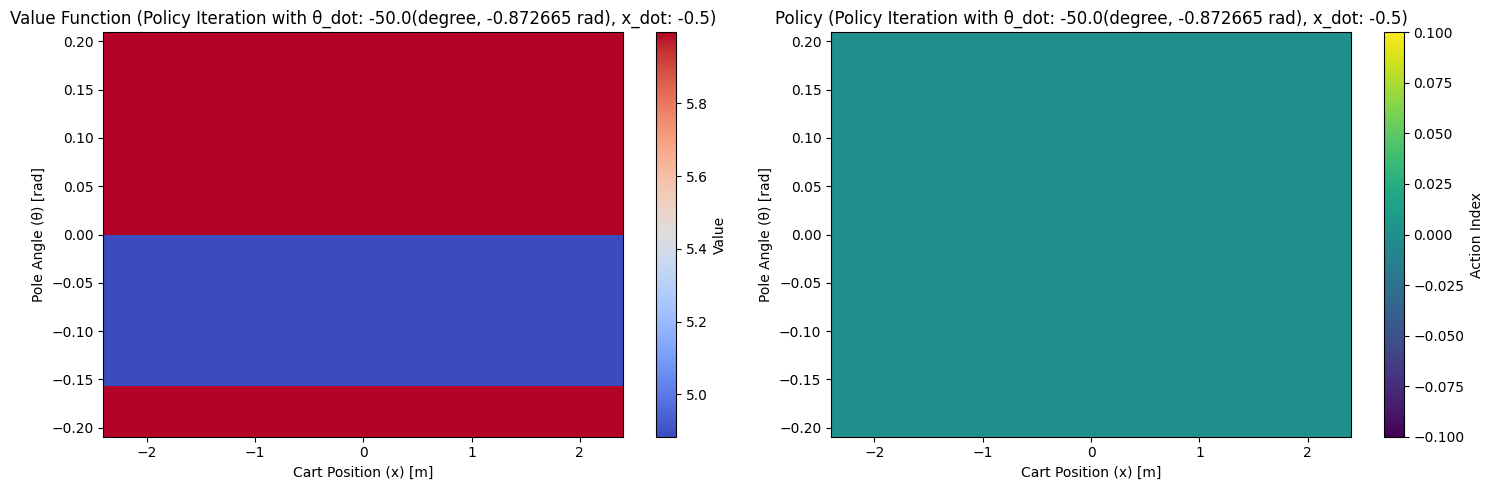

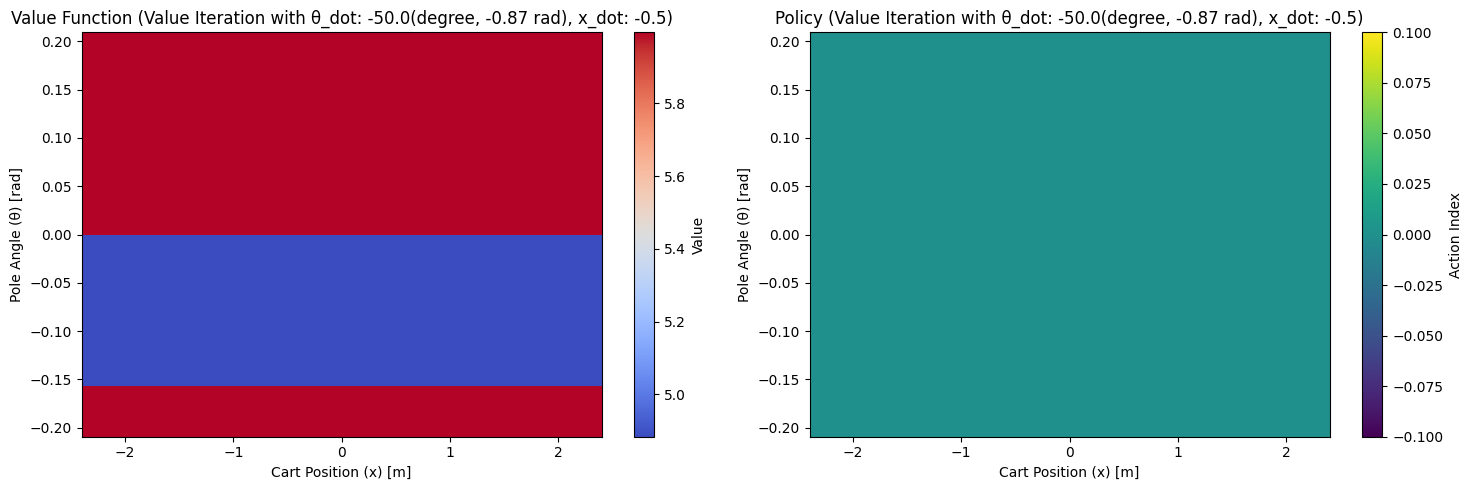

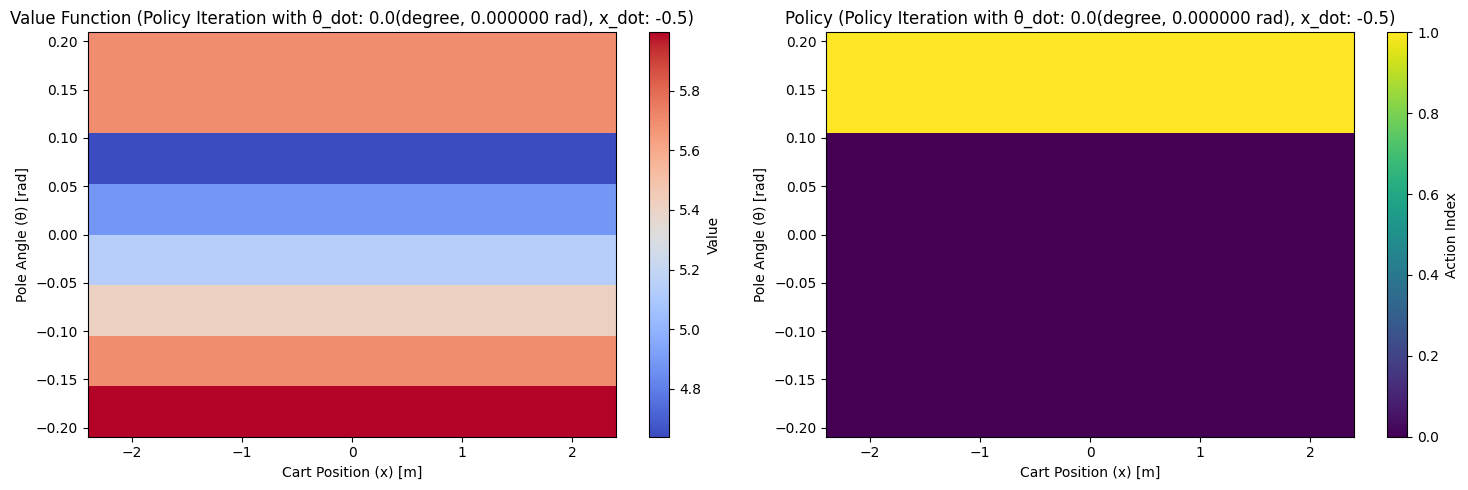

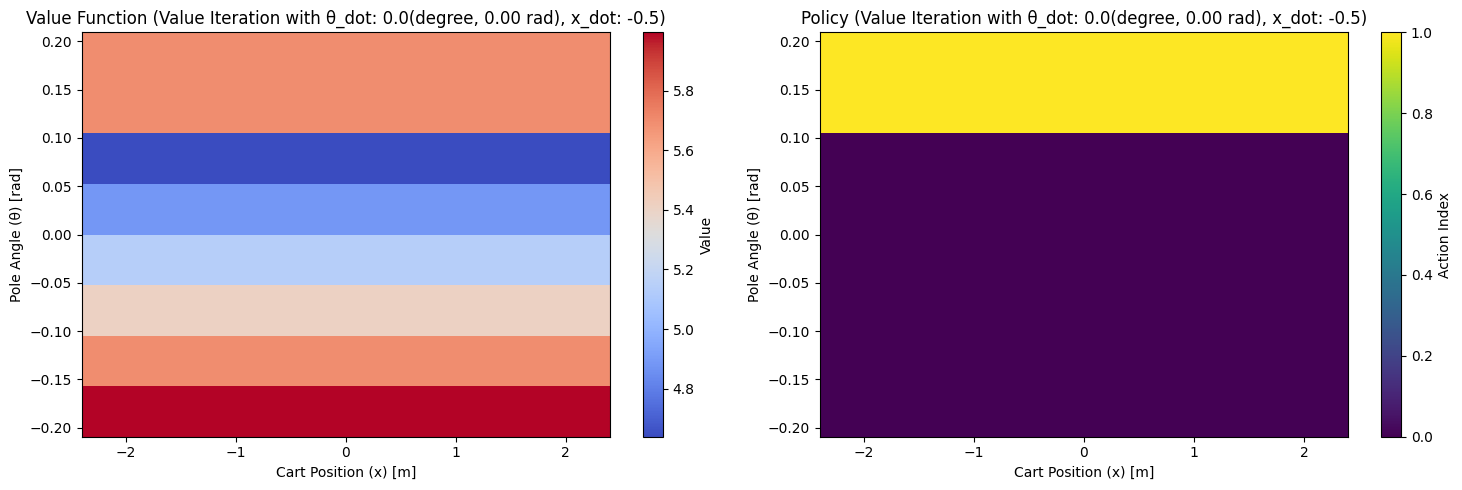

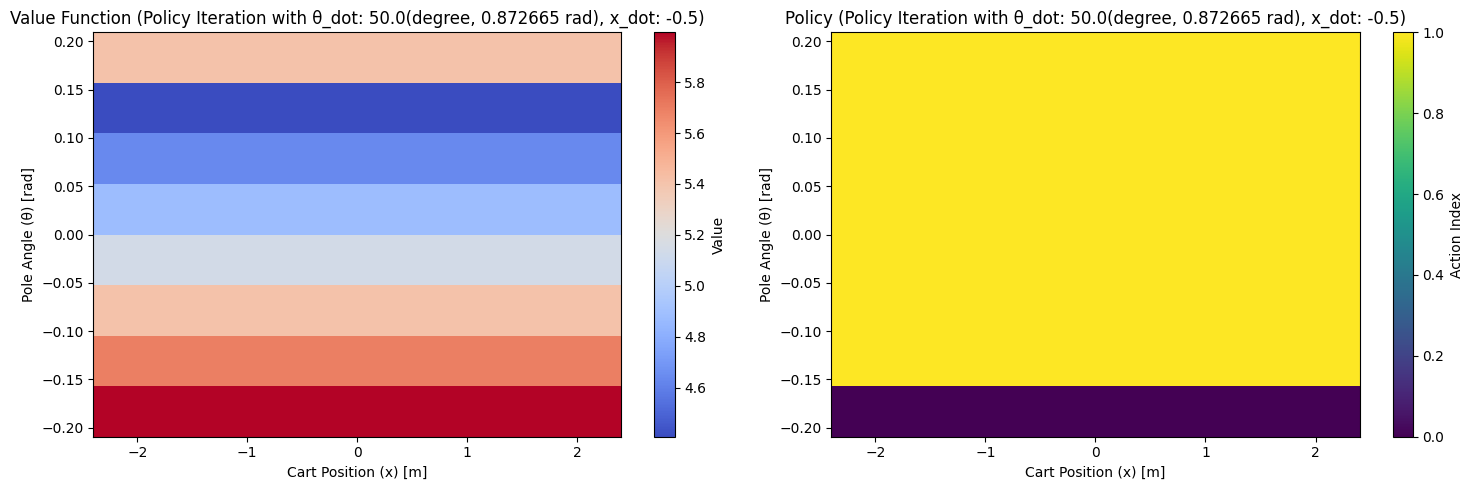

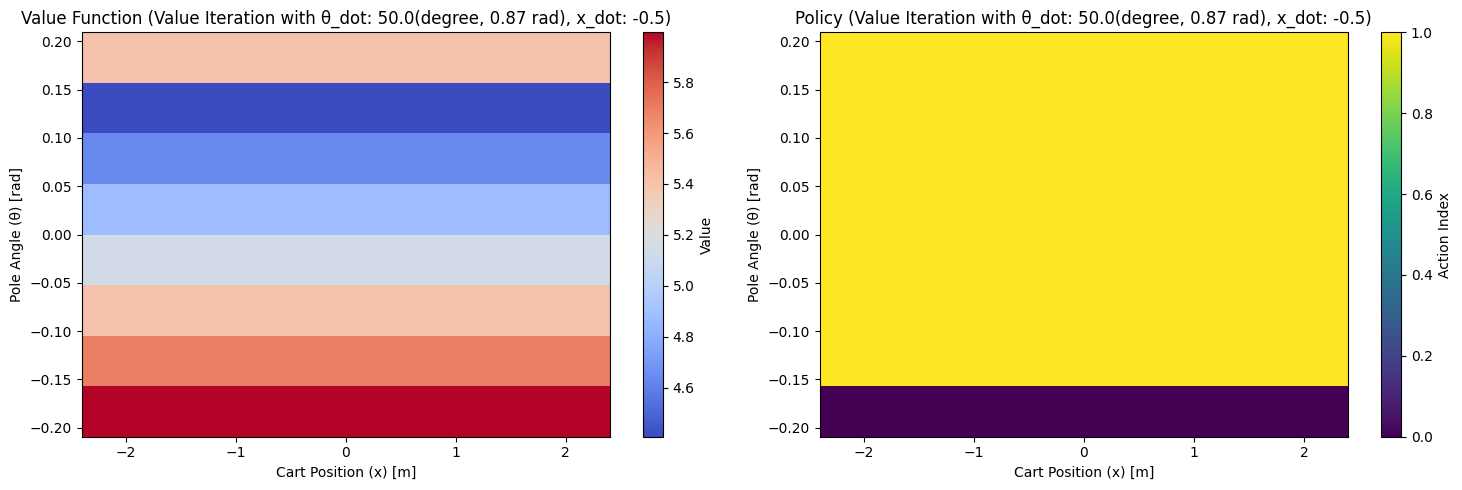

In [ ]:
## Library settings
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# multiple output in notebook without print()
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## Define CartPoleDynamics Class to set environments and define action and state-update function 
class CartPoleDynamics:
    def __init__(self):
        # System parameters
        self.M = 1.0  # Mass of the cart
        self.m = 0.1  # Mass of the pole
        self.g = -9.8  # Gravity
        self.l = 0.5  # Length of the pole
        self.mu_c = 0.0005  # Friction for the cart
        self.mu_p = 0.000002  # Friction for the pole
        self.delta_t = 0.02  # Time step
        self.actions = [-10, 10]  # Available actions (forces in Newtons)
        
        # State space discretization 
        self.theta_boxes = np.array([-12, -6, -1, 0, 1, 6, 12]) * np.pi / 180  # radians
        self.x_boxes = np.array([-2.4, -0.8, 0.8, 2.4])  # meters
        self.theta_dot_boxes = np.array([-50, 0, 50]) * np.pi / 180  # radians/s
        self.x_dot_boxes = np.array([-0.5, 0, 0.5])  # m/s
        
        # Define state space size (+1 because boxes create one more region than threshold)
        self.state_space_size = (
            len(self.theta_boxes) + 1,
            len(self.theta_dot_boxes) + 1,
            len(self.x_boxes) + 1,
            len(self.x_dot_boxes) + 1
        )

    def compute_accelerations(self, theta, theta_dot, x_dot, F):
        """Compute angular and linear accelerations based on the model."""
        sin_theta = np.sin(theta)
        cos_theta = np.cos(theta)
        
        # Calculate angular acceleration (theta_ddot)
        numerator = (self.g * sin_theta + 
                    cos_theta * ((-F - self.m * self.l * theta_dot**2 * sin_theta + 
                                self.mu_c * np.sign(x_dot)) / (self.M + self.m)) - 
                    self.mu_p * theta_dot / (self.m * self.l))
        denominator = self.l * (4.0/3.0 - (self.m * cos_theta**2) / (self.M + self.m))
        theta_ddot = numerator / denominator
        
        # Calculate linear acceleration (x_ddot)
        x_ddot = (F + self.m * self.l * (theta_dot**2 * sin_theta - theta_ddot * cos_theta) - 
                 self.mu_c * np.sign(x_dot)) / (self.M + self.m)
        
        return theta_ddot, x_ddot
    
    def update_state(self, state, action):
        """Update the state using Euler integration"""
        theta, theta_dot, x, x_dot = state
        F = action
        
        theta_ddot, x_ddot = self.compute_accelerations(theta, theta_dot, x_dot, F)
        
        # Update using Euler's method 
        x_dot += self.delta_t * x_ddot
        x += self.delta_t * x_dot
        theta_dot += self.delta_t * theta_ddot
        theta += self.delta_t * theta_dot
        
        return np.array([theta, theta_dot, x, x_dot])
    
    def discretize_state(self, state):
        """Discretize a continuous state based on provided thresholds"""
        theta, theta_dot, x, x_dot = state
        
        theta_idx = np.digitize(theta, self.theta_boxes, right=True)
        theta_dot_idx = np.digitize(theta_dot, self.theta_dot_boxes, right=True)
        x_idx = np.digitize(x, self.x_boxes, right=True)
        x_dot_idx = np.digitize(x_dot, self.x_dot_boxes, right=True)
        
        return (theta_idx, theta_dot_idx, x_idx, x_dot_idx)
        
    def is_state_valid(self, state):
        """Check if the state is within valid bounds"""
        """Here, we follow the 1st scenario of goal and reward given in final project tutorial"""
        theta, _, x, _ = state
        return (abs(theta) <= 12 * np.pi / 180 and abs(x) <= 2.4) # if this is True, the state is valid(not terminated)
    
## Define Dynamic Programming class for Policy Iteration and Value Iteraion Algorithm
class DynamicProgramming:
    # Use CartPoleDynamics class
    def __init__(self):
        self.dynamics = CartPoleDynamics()
        
    def _compute_state_value(self, state, action, value_function, gamma):
        """Method for computing value function for a state-action pair using Bellman Equation"""
        theta_idx, theta_dot_idx, x_idx, x_dot_idx = state
        
        # Convert discrete state to continuous
        # Assuming deterministic state transitions
        continuous_state = [
            self.dynamics.theta_boxes[theta_idx - 1] if theta_idx > 0 else -np.inf,
            self.dynamics.theta_dot_boxes[theta_dot_idx - 1] if theta_dot_idx > 0 else -np.inf,
            self.dynamics.x_boxes[x_idx - 1] if x_idx > 0 else -np.inf,
            self.dynamics.x_dot_boxes[x_dot_idx - 1] if x_dot_idx > 0 else -np.inf
        ]
        
        # Get next state using dynamics
        next_state_continuous = self.dynamics.update_state(continuous_state, action)
        next_state = self.dynamics.discretize_state(next_state_continuous)
        
        # Compute reward based on state validity
        reward = 1 if self.dynamics.is_state_valid(next_state_continuous) else 0
        
        # Compute value using Bellman equation
        return reward + gamma * value_function[next_state]
        
    """ Policy Iteration Algorithm"""    
    def policy_iteration(self, gamma = 0.95, threshold = 1e-4):
        # Initialize policy randomly (0: -10N, 1: 10N)
        policy = np.random.choice([0, 1], size = self.dynamics.state_space_size)
        # Initialize value functioni to zeros
        value_function = np.zeros(self.dynamics.state_space_size)
        """ Policy iteration consists of two alternating phases(evaluation and improvement)"""
        while True:
            # Policy Evaluation
            while True:
                delta = 0 # Track maximum change in value
                # Iterate through all states
                for theta_idx in range(self.dynamics.state_space_size[0]):
                    for theta_dot_idx in range(self.dynamics.state_space_size[1]):
                        for x_idx in range(self.dynamics.state_space_size[2]):
                            for x_dot_idx in range(self.dynamics.state_space_size[3]):
                                state = (theta_idx, theta_dot_idx, x_idx, x_dot_idx)
                                # Get action from current policy
                                action = self.dynamics.actions[policy[state]]
                                value = value_function[state]
                                # Compute new value using '_compute_state_value' method(Bellman equation)
                                new_value = self._compute_state_value(state, action, value_function, gamma)
                                value_function[state] = new_value
                                # Update maximum change
                                delta = max(delta, abs(value - new_value))
                                
                # Check if value function has converged, if converged then break the loop
                if delta < threshold:
                    break
            
            # Policy Improvement
            policy_stable = True
            # Iterate through all states
            for theta_idx in range(self.dynamics.state_space_size[0]):
                for theta_dot_idx in range(self.dynamics.state_space_size[1]):
                    for x_idx in range(self.dynamics.state_space_size[2]):
                        for x_dot_idx in range(self.dynamics.state_space_size[3]):
                            state = (theta_idx, theta_dot_idx, x_idx, x_dot_idx)
                            old_action = policy[state]
                            
                            # Find best action
                            action_values = []
                            # Iterate through all possible action
                            for action in self.dynamics.actions:
                                value = self._compute_state_value(state, action, value_function, gamma)
                                action_values.append(value)
                            
                            best_action = np.argmax(action_values)
                            policy[state] = best_action
                            
                            if old_action != best_action:
                                policy_stable = False
            # if policy_stable is False(meaning we found better action at least one state) then begin policy evaluation loop again 
            if policy_stable:
                break
                
        return policy, value_function
    
    ### Value Iteration Algorithm
    def value_iteration(self, gamma = 0.95, threshold = 1e-4):
        """ Updating Value function and action at the same time """
        # Initialize policy and value functions
        value_function = np.zeros(self.dynamics.state_space_size)
        policy = np.zeros(self.dynamics.state_space_size, dtype = int)
        
        while True:
            delta = 0 # Track maximum change in value
            for theta_idx in range(self.dynamics.state_space_size[0]):
                for theta_dot_idx in range(self.dynamics.state_space_size[1]):
                    for x_idx in range(self.dynamics.state_space_size[2]):
                        for x_dot_idx in range(self.dynamics.state_space_size[3]):
                            state = (theta_idx, theta_dot_idx, x_idx, x_dot_idx)
                            value = value_function[state]
                            
                            # Find maximum value over all actions
                            action_values = []
                            for action in self.dynamics.actions:
                                # Compute new value using '_compute_state_value' method(Bellman equation)
                                new_value = self._compute_state_value(state, action, value_function, gamma)
                                action_values.append(new_value)
                                
                            # Update value function with maximum value
                            value_function[state] = max(action_values)
                            # Update policy with best action
                            policy[state] = np.argmax(action_values)
                            # Update maximum change
                            delta = max(delta, abs(value - value_function[state]))
                                        
            if delta < threshold:
                break
                
        return policy, value_function
    
    # Function for Plotting
    def plot_results(self, policy, value_function, method_name, fixed_theta_dot_idx, fixed_x_dot_idx):
        """Plot value function and policy for a given slice of state space"""
        # Create a figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot value function
        # Extract 2D slice of the 4D value function and policy
        # We fix theta_dot and x_dot and plot theta versus x
        value_slice = value_function[:, fixed_theta_dot_idx, :, fixed_x_dot_idx]
        # plot value function
        im1 = ax1.imshow(value_slice, extent=[self.dynamics.x_boxes[0], 
                                            self.dynamics.x_boxes[-1],
                                            self.dynamics.theta_boxes[0],
                                            self.dynamics.theta_boxes[-1]],
                        aspect='auto', origin='lower', cmap='coolwarm')
        plt.colorbar(im1, ax=ax1, label='Value')
        ax1.set_title(f'Value Function ({method_name})')
        ax1.set_xlabel('Cart Position (x) [m]')
        ax1.set_ylabel('Pole Angle (θ) [rad]')
        
        # Plot policy
        policy_slice = policy[:, fixed_theta_dot_idx, :, fixed_x_dot_idx]
        im2 = ax2.imshow(policy_slice, extent=[self.dynamics.x_boxes[0],
                                             self.dynamics.x_boxes[-1],
                                             self.dynamics.theta_boxes[0],
                                             self.dynamics.theta_boxes[-1]],
                        aspect='auto', origin='lower', cmap='viridis')
        plt.colorbar(im2, ax=ax2, label='Action Index')
        ax2.set_title(f'Policy ({method_name})')
        ax2.set_xlabel('Cart Position (x) [m]')
        ax2.set_ylabel('Pole Angle (θ) [rad]')
        
        plt.tight_layout()
        plt.show()

## Implementation
def main():
    # Create instance of DP solver
    dp = DynamicProgramming()
    
    # Run policy iteration
    pi_policy, pi_value = dp.policy_iteration()
    
    # Run value iteration
    vi_policy, vi_value = dp.value_iteration()
    
    # Plot results for both methods
    # Different combinations of theta_dot and x_dot
    fixed_states = [(0, 0), (1, 0), (2, 0)]    
    for theta_dot_idx, x_dot_idx in fixed_states:
        # Plot policy iteration results
        dp.plot_results(pi_policy, pi_value, f"Policy Iteration with θ_dot: {dp.dynamics.theta_dot_boxes[theta_dot_idx]*180/np.pi}(degree, {dp.dynamics.theta_dot_boxes[theta_dot_idx]:2f} rad), x_dot: {dp.dynamics.x_dot_boxes[x_dot_idx]}", theta_dot_idx, x_dot_idx)
        
        # Plot value iteration results
        dp.plot_results(vi_policy, vi_value, f"Value Iteration with θ_dot: {dp.dynamics.theta_dot_boxes[theta_dot_idx]*180/np.pi}(degree, {dp.dynamics.theta_dot_boxes[theta_dot_idx]:.2f} rad), x_dot: {dp.dynamics.x_dot_boxes[x_dot_idx]}", theta_dot_idx, x_dot_idx)
    
### Algorithm Implementation and Plotting
if __name__ == "__main__":
    main()
    

### **Task 3_TD with Q-learning**


Running trials with discount rate: 0.9
Trial 1/10 average is 152.518
Trial 2/10 average is 159.718
Trial 3/10 average is 227.829
Trial 4/10 average is 245.983
Trial 5/10 average is 232.261
Trial 6/10 average is 253.216
Trial 7/10 average is 251.632
Trial 8/10 average is 260.86
Trial 9/10 average is 254.098
Trial 10/10 average is 252.374

Running trials with discount rate: 0.95
Trial 1/10 average is 256.227
Trial 2/10 average is 260.256
Trial 3/10 average is 253.716
Trial 4/10 average is 259.782
Trial 5/10 average is 252.58
Trial 6/10 average is 259.98
Trial 7/10 average is 255.28
Trial 8/10 average is 263.321
Trial 9/10 average is 248.138
Trial 10/10 average is 259.895

Running trials with discount rate: 0.99
Trial 1/10 average is 261.192
Trial 2/10 average is 243.561
Trial 3/10 average is 254.473
Trial 4/10 average is 257.553
Trial 5/10 average is 255.522
Trial 6/10 average is 252.957
Trial 7/10 average is 259.568
Trial 8/10 average is 252.509
Trial 9/10 average is 257.823
Trial 10/1

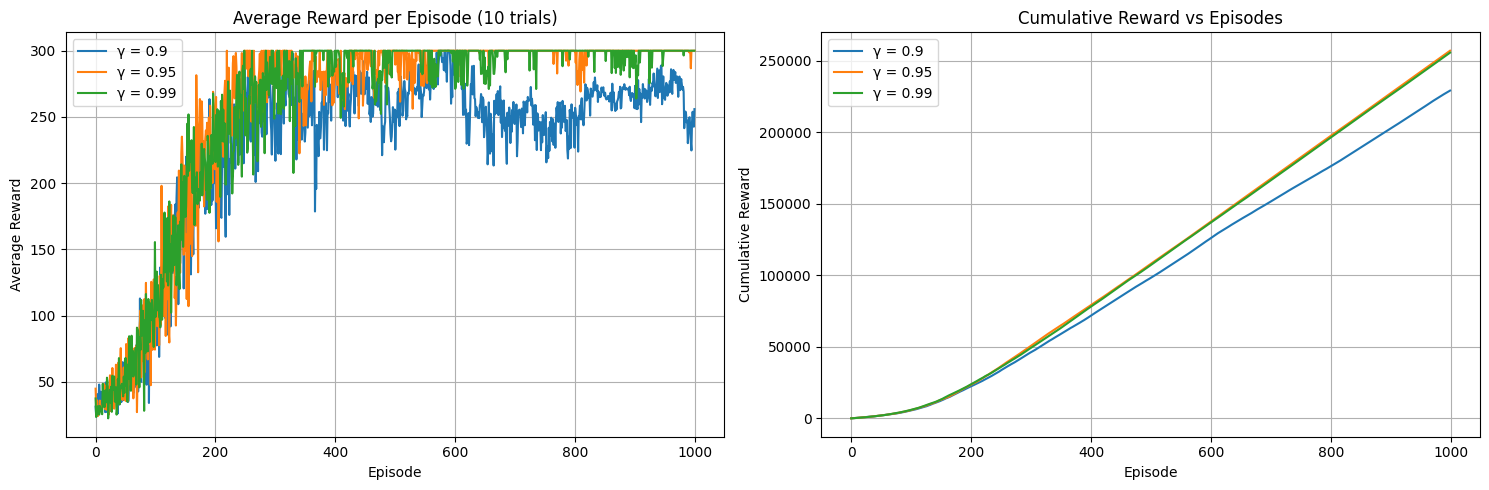

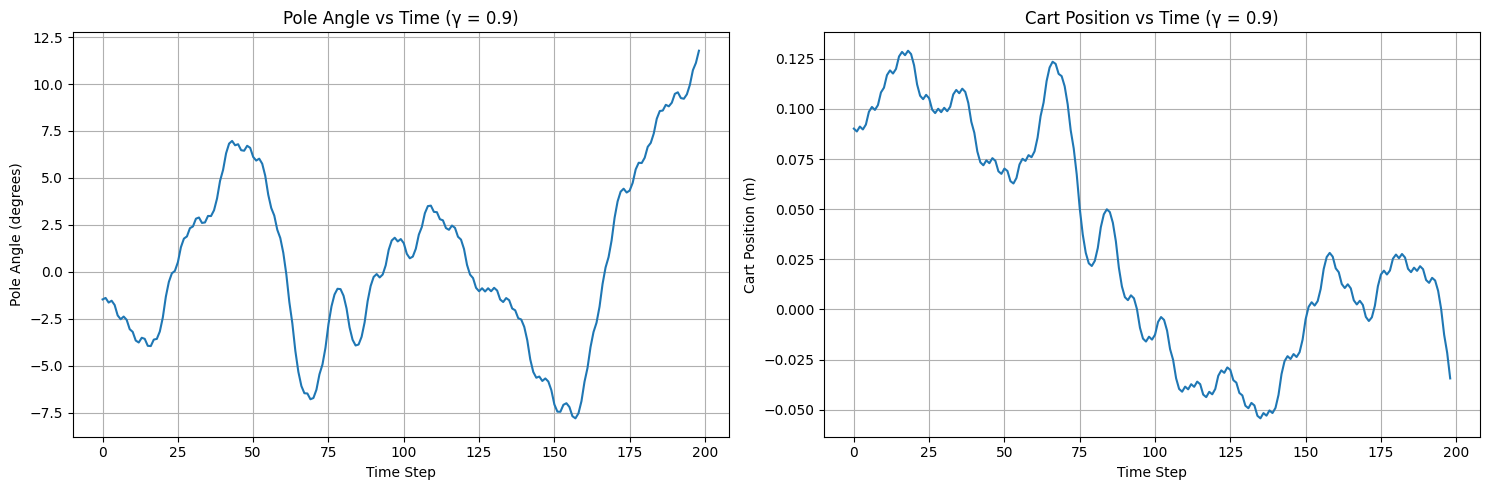

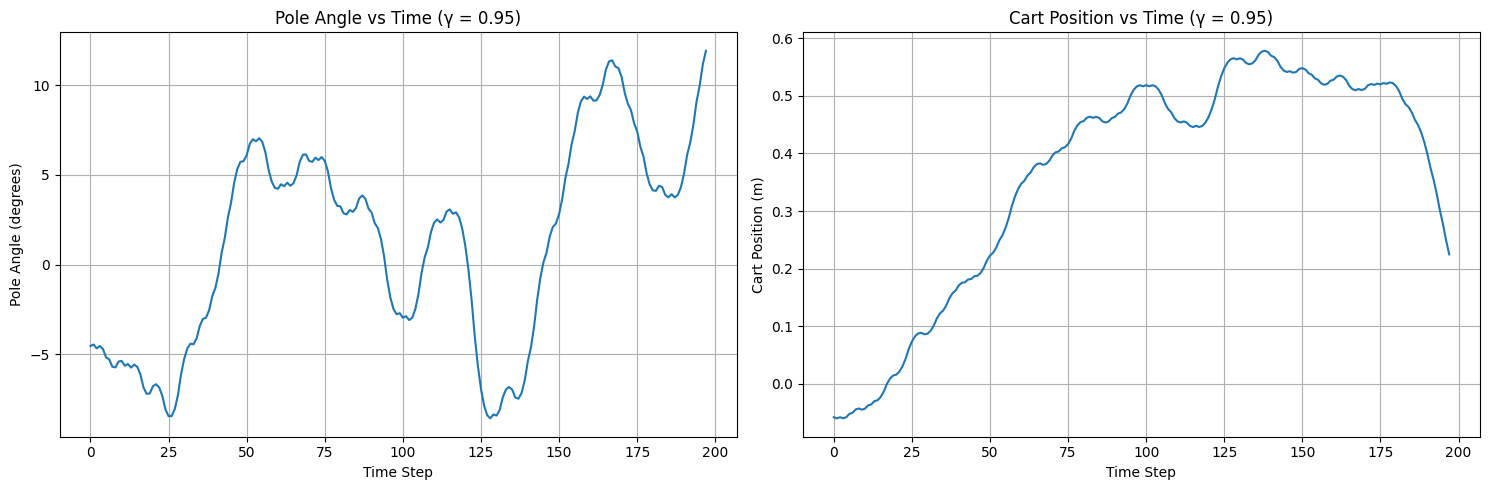

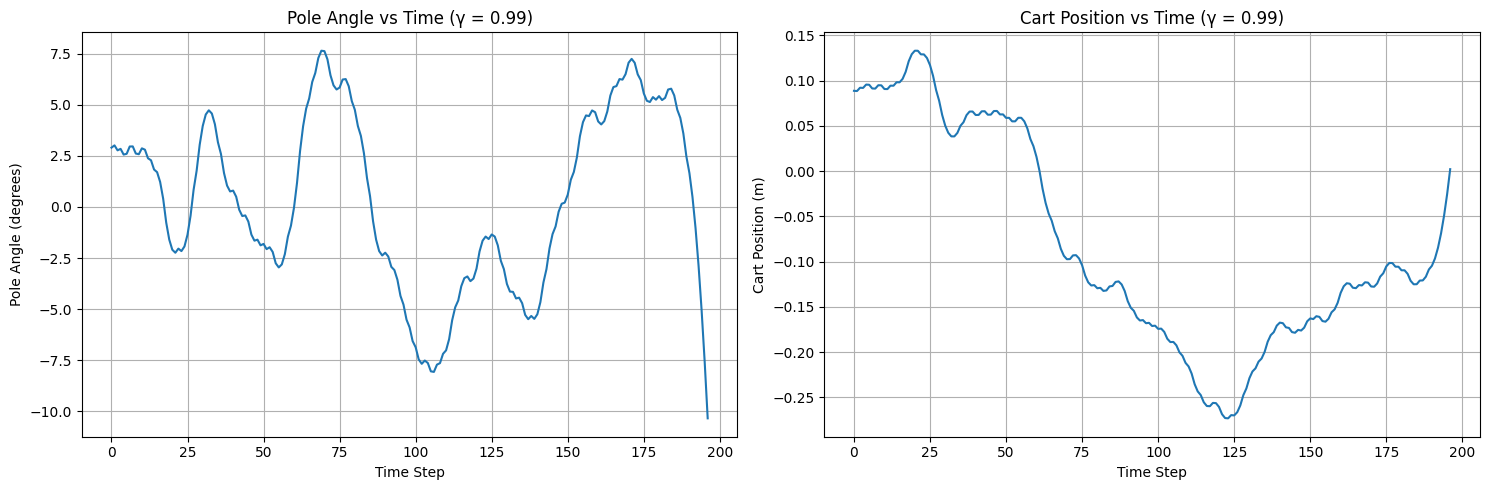

In [8]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import deque
import pandas as pd
from itertools import combinations


# multiple output in notebook without print()
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
### Define CartePoleDynamics including environment, parameter, state space setting 

        
### Define CartePoleDynamics including environment, parameter, state space setting 
class CartPoleDynamics:
    def __init__(self):
        # System parameters
        self.M = 1.0  # Mass of the cart
        self.m = 0.1  # Mass of the pole
        self.g = -9.8  # Gravity
        self.l = 0.5  # Length of the pole
        self.mu_c = 0.0005  # Friction for the cart
        self.mu_p = 0.000002  # Friction for the pole
        self.delta_t = 0.02  # Time step
        self.actions = [-10, 10]  # Available actions (forces in Newtons)
        
        # State space discretization (Boxes system)
        self.theta_boxes = np.array([-12, -6, -1, 0, 1, 6, 12]) * np.pi / 180  # radians
        self.x_boxes = np.array([-2.4, -0.8, 0.8, 2.4])  # meters
        self.theta_dot_boxes = np.array([-50, 0, 50]) * np.pi / 180  # radians/s
        self.x_dot_boxes = np.array([-0.5, 0, 0.5])  # m/s
        
        # State space size
        self.state_space_size = (
            len(self.theta_boxes) + 1, # 7+1=8 regions for theta
            len(self.theta_dot_boxes) + 1, # 3+1=4 regions for theta
            len(self.x_boxes) + 1, # 4+1=5 regions for theta
            len(self.x_dot_boxes) + 1 # 3+1=4 regions for theta
        )

    def compute_accelerations(self, theta, theta_dot, x_dot, F):
        """Compute angular and linear accelerations based on the model"""
        sin_theta = np.sin(theta)
        cos_theta = np.cos(theta)
        
        # Calculate theta_ddot (from equation 1)
        numerator = (self.g * sin_theta + 
                    cos_theta * ((-F - self.m * self.l * theta_dot**2 * sin_theta + 
                                self.mu_c * np.sign(x_dot)) / (self.M + self.m)) - 
                    self.mu_p * theta_dot / (self.m * self.l))
        denominator = self.l * (4.0/3.0 - (self.m * cos_theta**2) / (self.M + self.m))
        theta_ddot = numerator / denominator
        
        # Calculate x_ddot (from equation 1)
        x_ddot = (F + self.m * self.l * (theta_dot**2 * sin_theta - theta_ddot * cos_theta) - 
                 self.mu_c * np.sign(x_dot)) / (self.M + self.m)
        
        return theta_ddot, x_ddot
    
    def update_state(self, state, action):
        """Update state using Euler integration (equation 2)"""
        theta, theta_dot, x, x_dot = state
        
        theta_ddot, x_ddot = self.compute_accelerations(theta, theta_dot, x_dot, action)
        
        # Euler integration
        x_dot_new = x_dot + self.delta_t * x_ddot
        x_new = x + self.delta_t * x_dot
        theta_dot_new = theta_dot + self.delta_t * theta_ddot
        theta_new = theta + self.delta_t * theta_dot
        
        return np.array([theta_new, theta_dot_new, x_new, x_dot_new])

    def discretize_state(self, state):
        """Discretize state using the Boxes system"""
        theta, theta_dot, x, x_dot = state
        
        theta_idx = np.digitize(theta, self.theta_boxes)
        theta_dot_idx = np.digitize(theta_dot, self.theta_dot_boxes)
        x_idx = np.digitize(x, self.x_boxes)
        x_dot_idx = np.digitize(x_dot, self.x_dot_boxes)
        
        return (theta_idx, theta_dot_idx, x_idx, x_dot_idx)

    def is_terminal(self, state):
        """Check if state is terminal based on angle and position limits"""
        theta, _, x, _ = state
        return abs(theta) > 12 * np.pi / 180 or abs(x) > 2.4

    def reset(self):
        """Reset state to small random values near center"""
        theta = np.random.uniform(-0.1, 0.1)
        theta_dot = np.random.uniform(-0.1, 0.1)
        x = np.random.uniform(-0.1, 0.1)
        x_dot = np.random.uniform(-0.1, 0.1)
        return np.array([theta, theta_dot, x, x_dot])

### Define TemporalDiffence class for Implementing TD
class TemporalDifference:
    def __init__(self):
        self.dynamics = CartPoleDynamics()
        self.epsilon_start = 1.0 # start with 100% exploration
        self.epsilon_min = 0.01 # Minimum exploration rate
        self.epsilon_decay = 0.995 # Decay rate for exploration
        self.learning_rate = 0.1 # Learning rate(alpha)
        
        # Initialize Q-table with zeros
        self.q_table = np.zeros(self.dynamics.state_space_size + (2,))  # including 2 actions: -10N or +10N

    def get_action(self, state_discrete, epsilon):
        """Epsilon-greedy action selection"""
        """Select action that maximize Q-value """
        if np.random.random() < epsilon:
            return np.random.randint(2)  # Random action: 0 or 1
        return np.argmax(self.q_table[state_discrete])

    def get_reward(self, state):
        """Compute reward based on state"""
        # +1 reward while pole is upright and cart is within bounds
        if not self.dynamics.is_terminal(state):
            return 1.0
        return 0.0  # Terminal state

    def run_trial(self, discount_rate=0.95, n_episodes=1000):
        """Run one complete trial"""
        epsilon = self.epsilon_start
        episode_rewards = []
        cumulative_rewards = []
        total_reward = 0
        last_100_rewards = deque(maxlen = 100)
        successful_episode_data = None
        max_steps = 300  # Maximum steps per episode

        for episode in range(n_episodes):
            state = self.dynamics.reset()
            episode_reward = 0
            states_history = {'time': [], 'theta': [], 'x': []}
            
            for step in range(max_steps):
                # Record state
                states_history['time'].append(step)
                states_history['theta'].append(state[0] * 180 / np.pi)  # Convert to degrees
                states_history['x'].append(state[2])
                
                # Get action
                state_discrete = self.dynamics.discretize_state(state) 
                action_idx = self.get_action(state_discrete, epsilon)
                action = self.dynamics.actions[action_idx] # pick -10 or 10
                
                # Take action
                next_state = self.dynamics.update_state(state, action)
                reward = self.get_reward(next_state)
                done = self.dynamics.is_terminal(next_state)
                
                # Q-learning update
                next_state_discrete = self.dynamics.discretize_state(next_state)
                old_value = self.q_table[state_discrete + (action_idx,)]
                next_max = np.max(self.q_table[next_state_discrete])
                # Blending the old and new values for updating Q-value
                new_value = (1 - self.learning_rate) * old_value + \
                           self.learning_rate * (reward + discount_rate * next_max)
                self.q_table[state_discrete + (action_idx,)] = new_value
                
                state = next_state
                episode_reward += reward
                
                if done: # epsode termination check
                    break
            # Store successful episode data
            if episode_reward >= 195 and successful_episode_data is None:
                successful_episode_data = states_history.copy()

            # Update tracking variables
            episode_rewards.append(episode_reward)
            total_reward += episode_reward
            cumulative_rewards.append(total_reward)
            last_100_rewards.append(episode_reward)
            
            # Decay epsilon
            epsilon = max(self.epsilon_min, epsilon * self.epsilon_decay)
            
            # Check if solved
           # if len(last_100_rewards) == 100 and np.mean(last_100_rewards) >= 195.0:
           #     print(f"Solved at episode {episode}! Average reward: {np.mean(last_100_rewards):.2f}")

        return episode_rewards, cumulative_rewards, successful_episode_data

def run_experiments():
    agent = TemporalDifference()
    discount_rates = [0.9, 0.95, 0.99]
    results = {}
    
    for gamma in discount_rates:
        print(f"\nRunning trials with discount rate: {gamma}")
        trial_episode_rewards = []
        trial_cumulative_rewards = []
        trial_successful_states = None
        
        # Run 10 trials
        for trial in range(10):
            #print(f"Trial {trial + 1}/10")
            episode_rewards, cumulative_rewards, successful_states = agent.run_trial(gamma)
            trial_episode_rewards.append(episode_rewards)
            trial_cumulative_rewards.append(cumulative_rewards)
            print(f"Trial {trial+1}/10 average is {np.mean(episode_rewards)}")
            if successful_states is not None and trial_successful_states is None:
                trial_successful_states = successful_states
                
        # Average results across trials
        avg_episode_rewards = np.mean(trial_episode_rewards, axis=0)
        avg_cumulative_rewards = np.mean(trial_cumulative_rewards, axis=0)
        
        results[gamma] = {
            'episode_rewards': avg_episode_rewards,
            'cumulative_rewards': avg_cumulative_rewards,
            'successful_states': trial_successful_states
        }
    
    return results

def plot_results(results):
    # Plot episode rewards
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for gamma, data in results.items():
        plt.plot(data['episode_rewards'], label=f'γ = {gamma}')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.title('Average Reward per Episode (10 trials)')
    plt.legend()
    plt.grid(True)
    
    # Plot cumulative rewards
    plt.subplot(1, 2, 2)
    for gamma, data in results.items():
        plt.plot(data['cumulative_rewards'], label=f'γ = {gamma}')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Cumulative Reward vs Episodes')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show();
    
    # Plot successful episode states
    for gamma, data in results.items():
        if data['successful_states'] is not None:
            plt.figure(figsize=(15, 5))
            
            # Plot theta
            plt.subplot(1, 2, 1)
            plt.plot(data['successful_states']['time'], 
                    data['successful_states']['theta'])
            plt.xlabel('Time Step')
            plt.ylabel('Pole Angle (degrees)')
            plt.title(f'Pole Angle vs Time (γ = {gamma})')
            plt.grid(True)
            
            # Plot x
            plt.subplot(1, 2, 2)
            plt.plot(data['successful_states']['time'], 
                    data['successful_states']['x'])
            plt.xlabel('Time Step')
            plt.ylabel('Cart Position (m)')
            plt.title(f'Cart Position vs Time (γ = {gamma})')
            plt.grid(True)
            
            plt.tight_layout()
            plt.show();


def main():
    # Run experiments
    results = run_experiments()
    
    # Plot results
    plot_results(results)

if __name__ == "__main__":
    main()